In [2]:
#imports

import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import festim as F
from festim import t
from fenics import IntervalMesh, MeshFunction, CompiledSubDomain
from scipy.constants import Avogadro

In [3]:
#constants
T1, T2, T3 = 600 + 273.16, 500 + 273.16, 300 + 273.16
w_density = 6.3e28  # atomic density of tungsten
cucrzr_density = 9.2e28  # atom/m3

mean_depth_section_1 = 10e-9
reflection_ratio_section_1 = 0.6
tungsten_thickness = 0.003
cucrzr_thickness = 0.011
tol = 1e-14

folder = "replication"


In [4]:

tungsten = F.Material(
        id=1, D_0=1.5e-7, E_D=0.265, S_0=2.7e24, E_S=1.14,
        borders=[0, 3e-3], thermal_cond=173
            )

In [5]:
from fenics import IntervalMesh, MeshFunction, CompiledSubDomain

def simulation_with_interface(flux, simulation_time, thickness_1, thickness_2, n, T1, T2, T3, mean_depth, folder, rel_tol, abs_tol, vary, percent):
    tungsten = F.Material(
        id=1, D_0=1.5e-7, E_D=0.265, S_0=2.7e24, E_S=1.14,
        borders=[0, thickness_1], thermal_cond=173
            )

    cucrzr = cucrzr = F.Material(
        id=2, D_0=4.8e-7, E_D=0.42, S_0=4.27e23, E_S=0.39,
        borders=[thickness_1, thickness_2 + thickness_1], thermal_cond=320
        )

    tungsten_trap_1 = F.Trap(
        k_0 = 1.5e-7/((1.1e-10)**2 * 6 * w_density),
        E_k= 0.265, 
        p_0=1.2397e13,
        E_p=0.83,
        density = sp.Piecewise((6.3e28*0.00118, F.x < thickness_1), (0,True)),
        materials = [tungsten],
        id= 1
        )

    tungsten_trap_2 = F.Trap(
        k_0 = 1.5e-7/((1.1e-10)**2 * 6 * w_density),
        E_k= 0.265, 
        p_0=1.2397e13,    E_p=0.97,
        density = sp.Piecewise((6.3e28*0.000722, F.x < thickness_1),(0,True)),
        materials = [tungsten],
        id = 2
        )

    cucrzr_trap = F.Trap(
            k_0=4.8e-7 / ((2.556e-10)**2 * 1 * cucrzr_density),
            E_k=0.42,
            p_0=7.3472e12, 
            E_p=0.53+0.42,
            density= sp.Piecewise((3.7e24,F.x > thickness_1),(0,True)),
            materials=[cucrzr],
            id =4
            )
    if vary:
        induced_trap = F.NeutronInducedTrap(
                k_0 = 1.5e-7/((1.1e-10**2) * 6 * w_density),
                E_k= 0.265, 
                 p_0=1.2397e13,
                 E_p = 1.51,
                 phi = 6.3e-8,
                 K = 3.858e27,
                 A_0 = 0,
                 E_A = 1,
                 materials = [tungsten],
                 n_max = percent*w_density,
                 id=3
                )
      
    else:
        induced_trap = F.Trap(k_0=1.5e-7/(1.1e-10**2 * 6 * w_density),
                      E_k=0.265,
                      p_0=1e13,
                      E_p=1.51,
                      density = percent*w_density,
                      materials = tungsten,
                      id=3)

    materials = [tungsten, cucrzr]
    traps = [tungsten_trap_1, tungsten_trap_2, induced_trap,cucrzr_trap]
    
    #defining the mesh
    vertices_material_1 = np.linspace(0, thickness_1, n)
    vertices_material_2 = np.linspace(thickness_1, thickness_1 + thickness_2, n)
    #using concatenate allows you to combine the two linspaces and have different interval sizes for each material
    full_vertices = np.concatenate([vertices_material_1, vertices_material_2])
    #defining the mesh using fenics IntervalMesh
    mesh = IntervalMesh(len(full_vertices)-1, full_vertices.min(), full_vertices.max())
    #used to indicate the surfaces for bc application
    surface_markers = MeshFunction("size_t", mesh, mesh.topology().dim()-1)

    tol = 1e-14
    surface_markers.set_all(0)
    #defining each surface. CompiledSubDomain uses C++ syntax for the expressions
    left_surface = CompiledSubDomain('near(x[0], 0, tol)', tol = tol)
    right_surface = CompiledSubDomain('near(x[0], (thickness_1 + thickness_2), tol)', tol = tol, thickness_1 = thickness_1, thickness_2 = thickness_2)
    interface = CompiledSubDomain('near(x[0], thickness_1, tol)', tol = tol, thickness_1 = thickness_1)
    #the surface IDs
    left_id = 1
    right_id = 3
    interface_id = 2

    left_surface.mark(surface_markers, left_id)
    right_surface.mark(surface_markers, right_id)
    interface.mark(surface_markers, interface_id)
    #definining the full material regions
    volume_markers = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
    volume_markers.set_all(0)

    material_1_region = CompiledSubDomain('x[0] <= thickness_1 + tol', thickness_1 = thickness_1, tol = tol)
    material_2_region = CompiledSubDomain('x[0] > thickness_1 - tol', thickness_1=thickness_1, tol = tol)

    region_1_id = 1
    region_2_id = 2

    material_1_region.mark(volume_markers, region_1_id)
    material_2_region.mark(volume_markers, region_2_id)

    #defining the problem
    model = F.Simulation()

    model.mesh = F.Mesh(mesh = mesh, surface_markers = surface_markers, volume_markers = volume_markers)

    model.materials = materials
    model.traps = traps

    model.T=F.HeatTransferProblem(transient=False)

    boundary_conditions = [ F.ImplantationDirichlet(surfaces=left_id, phi=flux, R_p=mean_depth, D_0=1.5e-07, E_D=0.265),
    F.DirichletBC(surfaces=right_id, value=0, field=0),
    F.DirichletBC(surfaces=left_id, value=T1, field="T"),
    F.DirichletBC(surfaces=right_id, value=T3, field="T"),
    F.DirichletBC(surfaces=interface_id, value=T2, field="T")
    ]

    model.boundary_conditions = boundary_conditions

    model.dt = F.Stepsize(
    initial_value=0.5,
    stepsize_change_ratio=1.1,
    )

    model.settings = F.Settings(
        absolute_tolerance=abs_tol, 
        relative_tolerance=rel_tol, 
        final_time=simulation_time, 
        chemical_pot=True, 
        traps_element_type="DG"
    )


    total_mobile = F.TotalVolume("solute", volume=1)
    total_trap1 = F.TotalVolume("1", volume=1)  
    total_trap2 = F.TotalVolume("2", volume=1)
    total_trap3 = F.TotalVolume("3", volume=1)
    total_trap4 = F.TotalVolume("4", volume=2)
    total_retention_1 = F.TotalVolume("retention", volume = 1)
    total_retention_2 =  F.TotalVolume("retention", volume = 2)
    derived = [total_mobile, total_trap1, total_trap2, total_trap3, total_trap4, total_retention_1, total_retention_2]

    text_exports = [
    #F.TXTExport(field="solute", filename=folder+"/mobile_conc.txt", times=[simulation_time - 1]),
    #F.TXTExport(field="1", filename=folder+"/trap_1.txt", times=[simulation_time - 1]),
    #F.TXTExport(field="2", filename=folder+"/trap_2.txt", times=[simulation_time - 1]),
    #F.TXTExport(field="3", filename=folder+"/trap_3.txt", times=[simulation_time - 1]),
    #F.XDMFExport(field="retention", label = "retention",filename=folder+"/reten.xdmf"),
    F.TXTExport(field="T", filename = folder +"/temp.txt", times = [1, simulation_time])]
    
  
    exports = text_exports + [F.DerivedQuantities(derived, filename=folder+"/derived_qs.csv")]

    model.exports = exports

    model.initialise()
    model.run()



In [6]:
def simulation_w_only(flux, simulation_time, thickness_1, n, T1, T2, mean_depth, folder, rel_tol, abs_tol, vary, percent):
    tungsten = F.Material(
        id=1, D_0=1.5e-7, E_D=0.265, S_0=2.7e24, E_S=1.14,
        borders=[0, thickness_1], thermal_cond=173
            )

    tungsten_trap_1 = F.Trap(
        k_0 = 1.5e-7/((1.1e-10)**2 * 6 * w_density),
        E_k= 0.265, 
        p_0=1.2397e13,
        E_p=0.83,
        density = sp.Piecewise((6.3e28*0.00118, F.x < thickness_1), (0,True)),
        materials = [tungsten]
        )

    tungsten_trap_2 = F.Trap(
        k_0 = 1.5e-7/((1.1e-10)**2 * 6 * w_density),
        E_k= 0.265, 
        p_0=1.2397e13,    E_p=0.97,
        density = sp.Piecewise((6.3e28*0.000722, F.x < thickness_1),(0,True)),
        materials = [tungsten]
        )
    if vary:
        induced_trap = F.NeutronInducedTrap(
                k_0 = 1.5e-7/((1.1e-10**2) * 6 * w_density),
                E_k= 0.265, 
                 p_0=1.2397e13,
                 E_p = 1.51,
                 phi = 6.3e-8,
                 K = 3.858e27,
                 A_0 = 0,
                 E_A = 1,
                 materials = [tungsten],
                 n_max = percent*w_density
                )
    else:
        induced_trap = F.Trap(k_0=1.5e-7/(1.1e-10**2 * 6 * w_density),
                      E_k=0.265,
                      p_0=1e13,
                      E_p=1.51,
                      density = percent*w_density,
                      materials = tungsten)
    materials = [tungsten]
    traps = [tungsten_trap_1, tungsten_trap_2, induced_trap]
    
    
    #defining the mesh
    vertices_material_1 = np.linspace(0, thickness_1, n)
   
    #defining the problem
    model = F.Simulation()

    model.mesh = F.MeshFromVertices(vertices_material_1)
    model.materials = materials
    model.traps = traps

    model.T=F.HeatTransferProblem(transient=False)

    boundary_conditions = [ F.ImplantationDirichlet(surfaces=1, phi=flux, R_p=mean_depth, D_0=1.5e-07, E_D=0.265),
    F.DirichletBC(surfaces=2, value=0, field=0),
    F.DirichletBC(surfaces=1, value=T1, field="T"),
    F.DirichletBC(surfaces=2, value=T2, field="T"),
    ]

    model.boundary_conditions = boundary_conditions

    model.dt = F.Stepsize(
    initial_value=0.5,
    stepsize_change_ratio=1.1,
    )

    model.settings = F.Settings(
        absolute_tolerance=abs_tol, 
        relative_tolerance=rel_tol, 
        final_time=simulation_time, 
        chemical_pot=True, 
        traps_element_type="DG"
    )


    total_mobile = F.TotalVolume("solute", volume=1)
    total_trap1 = F.TotalVolume("1", volume=1)  
    total_trap2 = F.TotalVolume("2", volume=1)
    total_trap3 = F.TotalVolume("3", volume=1)
    derived = [total_mobile, total_trap1, total_trap2, total_trap3]

    text_exports = [
    #F.TXTExport(field="solute", filename=folder+"/mobile_conc.txt", times=[simulation_time - 1]),
    #F.TXTExport(field="1", filename=folder+"/trap_1.txt", times=[simulation_time - 1]),
    #F.TXTExport(field="2", filename=folder+"/trap_2.txt", times=[simulation_time - 1]),
    #F.TXTExport(field="3", filename=folder+"/trap_3.txt", times=[simulation_time - 1]),
    #F.TXTExport(field="retention", filename=folder+"/reten.txt", times=[simulation_time - 1]),
    F.TXTExport(field="T", filename = folder +"/temp.txt", times = [1, simulation_time])]
    
    exports = text_exports + [F.DerivedQuantities(derived, filename=folder+"/derived_qs.csv")]

    model.exports = exports

    model.initialise()
    model.run()

Modelling 0-1% Damage for 30 days

In [29]:
damage_trap_1perc = F.NeutronInducedTrap(
    k_0 = 1.5e-7/((1.1e-10**2) * 6 * w_density),
    E_k= 0.265, 
    p_0=1.2397e13,
    E_p = 1.51,
    phi = 6.3e-8,
    K = 3.858e27,
    A_0 = 0,
    E_A = 1,
    materials = [tungsten],
    n_max = 0.01*w_density
)


In [36]:
#section 1
simulation_with_interface(1e23, 
              4e7, 
              3e-3, 
              11e-3,   
               10000,
               600+273.15, 500+273.15, 300+273.15,
               10e-9,
               "div_sec_1_1perc_start_full",
               1e-8,
               1e12,
               True,
               0.01)

Defining variational problem heat transfers
Solving stationary heat equation
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/celyn/.local/lib/python3.10/site-packages/festim/exports/derived_quantities/derived_quantities.py:52: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(
/home/celyn/.local/lib/python3.10/site-packages/festim/generic_simulation.py:334: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)


100.0 %        4.0e+07 s    Ellapsed time so far: 222.7 s


In [9]:
#section 2
simulation_with_interface(1e24, 
              4e7, 
              10e-3, 
              2.5e-3, 
               10000,
               1300+273.16, 400+273.16, 200+273.16,
               10e-9,
               "div_sec_2_1perc_start_full",
               1e-8,
               1e12,
              True,
               0.01)


Defining variational problem heat transfers
Solving stationary heat equation
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/celyn/.local/lib/python3.10/site-packages/festim/exports/derived_quantities/derived_quantities.py:52: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(
/home/celyn/.local/lib/python3.10/site-packages/festim/generic_simulation.py:334: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)


100.0 %        4.0e+07 s    Ellapsed time so far: 658.9 s


In [18]:
#ofw
simulation_with_interface(1e21, 
              4e7, 
              2e-3, 
              2.5e-3,  
              10000,
              706+273.16, 680+273.16, 620+273.16,
              18e-9,
              "ofw_1perc_start_full",
              1e-8,
              1e12,
              True,
              0.01)


Defining variational problem heat transfers
Solving stationary heat equation
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/celyn/.local/lib/python3.10/site-packages/festim/exports/derived_quantities/derived_quantities.py:52: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(
/home/celyn/.local/lib/python3.10/site-packages/festim/generic_simulation.py:334: UserWarning: To ensure that TXTExport exports data at the desired times TXTExport.times are added to milestones
  warnings.warn(msg)


100.0 %        4.0e+07 s    Ellapsed time so far: 170.0 s


In [12]:
#ifw
simulation_with_interface(0, 
              4e7, 
              9e-3, 
              3e-3,  
               10000,
               400+273.16, 300+273.16, 245+273.16,
               15e-9,
               "ifw_1perc_start_full",
               1e-8,
               1e12,
                True,
               0.01)


Defining variational problem heat transfers
Solving stationary heat equation
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/celyn/.local/lib/python3.10/site-packages/festim/exports/derived_quantities/derived_quantities.py:52: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


100.0 %        4.0e+07 s    Ellapsed time so far: 71.0 s


In [13]:
#limiters
simulation_w_only(2e22, 
              4e7, 
              6e-3,  
               10000,
               750+273.16, 400+273.16,
               3e-9,
               "limiter_1perc_start_full",
               1e-8,
               1e12,
                True,
               0.01)


Defining variational problem heat transfers
Solving stationary heat equation
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...


/home/celyn/.local/lib/python3.10/site-packages/festim/exports/derived_quantities/derived_quantities.py:52: DeprecationWarning: The derived_quantities attribute will be deprecated in a future release, please use festim.DerivedQuantities as a list instead
  warnings.warn(


100.0 %        4.0e+07 s    Ellapsed time so far: 103.0 s


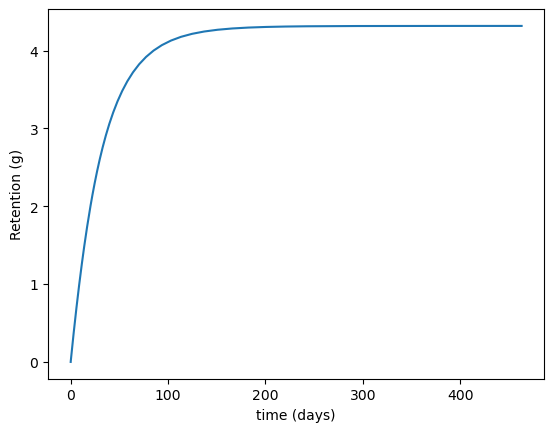

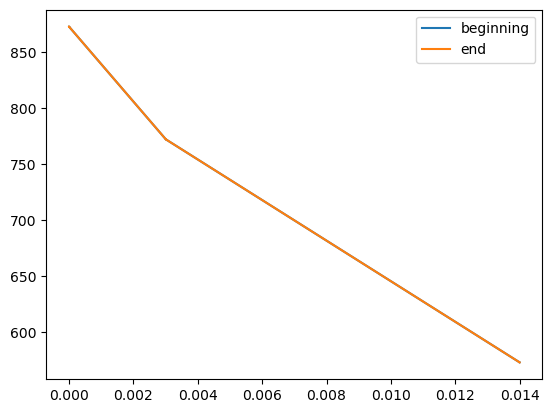

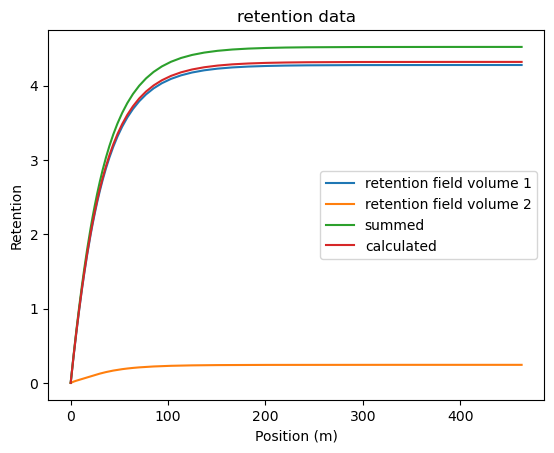

In [37]:
#this is just trying to work out what field is best to use to calculate retention- exporting the retention field for each volume vs summing each individual trap contribution plus the mobile hydrogen gives slightly different results

folder = "div_sec_1_1perc_start_full"

csv_data = np.genfromtxt(fname = folder+"/derived_qs.csv", dtype = 'float', delimiter = ',', skip_header = True)

retention = (np.array(csv_data[:,1]/Avogadro/2*3)
    +np.array(csv_data[:,2]/Avogadro/2*3)
    +np.array(csv_data[:,3]/Avogadro/2*3)
    +np.array(csv_data[:,4]/Avogadro/2*3)
    +np.array(csv_data[:,5]/Avogadro/2*3)
    )
time_days = csv_data[:,0]/24/3600
plt.plot(time_days, retention[:])
plt.xlabel("time (days)")
plt.ylabel("Retention (g)")
plt.show()

#trap_1_data = np.genfromtxt(folder+"/trap_1.txt", dtype = 'float', delimiter = ',', skip_header=True)
#trap_2_data = np.genfromtxt(folder+"/trap_2.txt", dtype = 'float', delimiter = ',', skip_header=True)
#trap_3_data = np.genfromtxt(folder+"/trap_3.txt", dtype = 'float', delimiter = ',', skip_header=True)
#trap_4_data = np.genfromtxt(folder+"/trap_4.txt", dtype = 'float', delimiter = ',', skip_header=True)
#mobile_data = np.genfromtxt(folder+"/mobile_conc.txt", dtype = 'float', delimiter = ',', skip_header=True)
#reten_data = np.genfromtxt(folder+"/reten.txt", dtype = 'float', delimiter = ',', skip_header=True)
temp_data = np.genfromtxt(folder+"/temp.txt", dtype = 'float', delimiter = ',', skip_header=True)
"""
plt.plot(trap_1_data[:,0], np.log(trap_1_data[:,1]), label = "Trap 1")
plt.plot(trap_2_data[:,0], np.log(trap_2_data[:,1]), label = "Trap 2")
plt.plot(trap_3_data[:,0], np.log(trap_3_data[:,1]), label = "Trap 3")
plt.plot(trap_4_data[:,0], np.log(trap_4_data[:,1]), label = "Damage Trap")
plt.xlabel("Position (m)")
plt.ylabel("Log trap concentration")
plt.legend()
plt.show()

plt.plot(mobile_data[:,0], mobile_data[:,1])
plt.title("mobile conc")
plt.xlabel("Position (m)")
plt.ylabel("Mobile Concentration")
plt.show()

plt.plot(reten_data[:,0], reten_data[:,1])
plt.ylabel("Retention")
plt.xlabel("Position (m)")
plt.title('retention data')
plt.show()
"""
plt.plot(temp_data[:,0], temp_data[:,1], label = "beginning")
plt.plot(temp_data[:,0], temp_data[:,2], label = "end")
plt.legend()
plt.show()
sum = csv_data[:,6]/Avogadro/2*3 + csv_data[:,7]/Avogadro/2*3
plt.plot(csv_data[:,0]/24/3600, csv_data[:,6]/Avogadro/2*3, label = 'retention field volume 1')
plt.plot(csv_data[:,0]/24/3600, csv_data[:,7]/Avogadro/2*3, label = 'retention field volume 2')
plt.plot(csv_data[:,0]/24/3600, sum, label = "summed")
plt.plot(csv_data[:,0]/24/3600, retention[:], label = 'calculated')
#plt.plot(csv_data[:,0]/24/3600, csv_data[:,10]/Avogadro/2*3, label = 'excel ind sum')
#plt.plot(csv_data[:,0]/24/3600, csv_data[:,11]/Avogadro/2*3, label = 'excel retention sum')
plt.ylabel("Retention")
plt.xlabel("Position (m)")
plt.title('retention data')
plt.legend()
plt.show()

168
417
168
168
168


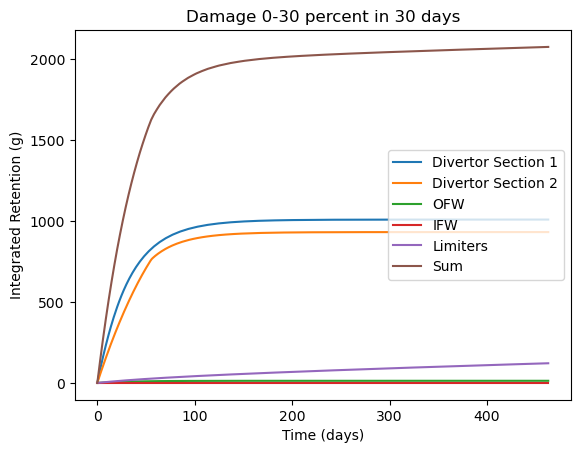

In [18]:
from scipy.interpolate import interp1d

common_time = np.linspace(0, 4e7, 160)
labels = ["Divertor Section 1", "Divertor Section 2", "OFW", "IFW", "Limiters"]
folders = ["div_sec_1_1perc_start_full", "div_sec_2_1perc_start_full", "ofw_1perc_start_full", "ifw_1perc_start_full", "limiter_1perc_start_full"]
section_areas = [233.93, 124.48, 331, 120, 102.6]

plt.figure()
full_data = np.zeros(160)
for i in range(len(folders)):
    if folders[i] != "limiter_1perc_start_full":
        csv_data = np.genfromtxt(fname = folders[i]+"/derived_qs.csv", dtype = 'float', delimiter = ',', skip_header = True)
        print(len(csv_data))
        retention = (np.array(csv_data[:,1])
          +np.array(csv_data[:,2])
          +np.array(csv_data[:,3])
          +np.array(csv_data[:,4])
          +np.array(csv_data[:,5])
          )
    else:
        csv_data = np.genfromtxt(fname = folders[i]+"/derived_qs.csv", dtype = 'float', delimiter = ',', skip_header = True)
        print(len(csv_data))
        retention = (np.array(csv_data[:,1])
          +np.array(csv_data[:,2])
          +np.array(csv_data[:,3])
          +np.array(csv_data[:,4])
          )       
    
    retention = retention*section_areas[i]
    reten_interp = interp1d(csv_data[:,0], retention, kind = 'linear', fill_value = 'extrapolate')
    reten_temp =reten_interp(common_time)
    full_data=full_data + reten_temp
    plt.plot(csv_data[:,0]/24/3600, retention[:]/Avogadro/2*3, label = labels[i])

plt.plot(common_time/24/3600, full_data/Avogadro/2*3, label = "Sum")
plt.xlabel("Time (days)")
plt.ylabel("Integrated Retention (g)")
plt.legend()
plt.title("Damage 0-30 percent in 30 days")

plt.show()

    

Modelling 1% trap from beginning

In [ ]:
induced_trap_1perc = F.Trap(k_0=1.5e-7/(1.1e-10**2 * 6 * w_density),
                      E_k=0.265,
                      p_0=1e13,
                      E_p=1.51,
                      density = 1e-2*w_density,
                      materials = tungsten)

In [ ]:
#section 1
simulation_with_interface(1e23, 
              500*3600*24, 
              3e-3, 
              11e-3,  
               5000,
               600+273.15, 500+273.15, 300+273.15,
               10e-9,
               "div_sec_1_1perc_full",
               1e-10,
               1e12,
               False,
               0.01)

In [ ]:
#section 2
simulation_with_interface(1e24, 
              500*3600*24, 
              10e-3, 
              2.5e-3, 
               2500,
               1300+273.16, 400+273.16, 200+273.16,
               10e-9,
               "div_sec_2_1perc_full",
               1e-10,
               1e14,
               False,
               0.01)

In [ ]:
#ofw
simulation_with_interface(1e21, 
              500*3600*24, 
              2e-3, 
              2.5e-3,  
              5000,
              706+273.16, 680+273.16, 620+273.16,
              18e-9,
              "ofw_1perc_full",
              1e-10,
              1e10,
              False,
              0.01)

In [ ]:
#ifw
simulation_with_interface(0, 
              500*3600*24, 
              9e-3, 
              3e-3, 
               5000,
               400+273.16, 300+273.16, 245+273.16,
               15e-9,
               "ifw_1perc_full",
               1e-10,
               1e10,
               False,
               0.01)


In [ ]:
#limiters
simulation_w_only(2e22, 
              500*3600*24, 
              6e-3,  
               5000,
               750+273.16, 400+273.16,
               3e-9,
               "limiter_1perc_full",
               1e-8,
               1e12,
               False,
               0.01)

In [ ]:
from scipy.interpolate import interp1d

common_time = np.linspace(0, 500*3600*24, 160)
labels = ["Divertor Section 1", "Divertor Section 2", "OFW", "IFW", "Limiters"]
folders = ["div_sec_1_1perc_full", "div_sec_2_1perc_full", "ofw_1perc_full", "ifw_1perc_full", "limiter_1perc_full"]
section_areas = [233.93, 124.48, 331, 120, 102.6]

plt.figure()
full_data = np.zeros(160)
for i in range(len(folders)):
    if folders[i] != "limiter_1perc_full":
        csv_data = np.genfromtxt(fname = folders[i]+"/derived_qs.csv", dtype = 'float', delimiter = ',', skip_header = True)
        print(len(csv_data))
        retention = (np.array(csv_data[:,1])
          +np.array(csv_data[:,2])
          +np.array(csv_data[:,3])
          +np.array(csv_data[:,4])
          +np.array(csv_data[:,5])
          )
    else:
        csv_data = np.genfromtxt(fname = folders[i]+"/derived_qs.csv", dtype = 'float', delimiter = ',', skip_header = True)
        print(len(csv_data))
        retention = (np.array(csv_data[:,1])
          +np.array(csv_data[:,2])
          +np.array(csv_data[:,3])
          +np.array(csv_data[:,4])
          )       
    
    retention = retention*section_areas[i]
    reten_interp = interp1d(csv_data[:,0], retention, kind = 'linear', fill_value = 'extrapolate')
    reten_temp =reten_interp(common_time)
    full_data=full_data + reten_temp
    plt.plot(csv_data[:,0]/24/3600, retention[:]/Avogadro/2*3, label = labels[i])

plt.plot(common_time/24/3600, full_data/Avogadro/2*3, label = "Sum")
plt.xlabel("Time (days)")
plt.ylabel("Integrated Retention (g)")
plt.title("Damage 1 percent from start, ignoring RR")
plt.legend()
plt.axvline(70, color = "blue", linestyle = "dashed")
plt.axvline(90, color = "red", linestyle = "dashed")

Damage 2% from start

In [ ]:
induced_trap_2perc = F.Trap(k_0=1.5e-7/(1.1e-10**2 * 6 * w_density),
                      E_k=0.265,
                      p_0=1e13,
                      E_p=1.51,
                      density = 2e-2*w_density,
                      materials = tungsten)

In [ ]:
#section 1
simulation_with_interface(1e23, 
              500*3600*24, 
              3e-3, 
              11e-3,   
               5000,
               600+273.15, 500+273.15, 300+273.15,
               10e-9,
               "div_sec_1_2perc_full",
               1e-8,
               1e12,
               False,
               0.02)

In [ ]:
#section 2
simulation_with_interface(1e24, 
              500*3600*24, 
              10e-3, 
              2.5e-3, 
               2500,
               1300+273.16, 400+273.16, 200+273.16,
               10e-9,
               "div_sec_2_2perc_full",
               1e-6,
               1e14,
               False,
               0.02)

In [ ]:
#ofw
simulation_with_interface(1e21, 
              500*3600*24, 
              2e-3, 
              2.5e-3, 
              5000,
              706+273.16, 680+273.16, 620+273.16,
              18e-9,
              "ofw_2perc_full",
              1e-8,
              1e12,
              False,
              0.02)

In [ ]:
#ifw
simulation_with_interface(0, 
              500*3600*24, 
              9e-3, 
              3e-3, 
               5000,
               400+273.16, 300+273.16, 245+273.16,
               15e-9,
               "ifw_2perc_full",
               1e-8,
               1e12,
               False,
               0.02)


In [ ]:
#limiters
simulation_w_only(2e22, 
              500*3600*24, 
              6e-3,  
               5000,
               750+273.16, 400+273.16,
               3e-9,
               "limiter_2perc_full",
               1e-8,
               1e12,
               False,
               0.02)

230
3669
169
169
169


/home/celyn/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/celyn/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


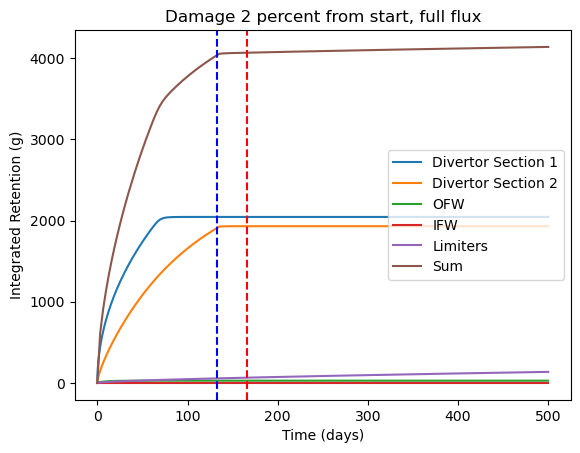

In [7]:
from scipy.interpolate import interp1d

common_time = np.linspace(0, 500*3600*24, 160)
labels = ["Divertor Section 1", "Divertor Section 2", "OFW", "IFW", "Limiters"]
folders = ["div_sec_1_2perc_full", "div_sec_2_2perc_full", "ofw_2perc_full", "ifw_2perc_full", "limiter_2perc_full"]
section_areas = [233.93, 124.48, 331, 120, 102.6]

plt.figure()
full_data = np.zeros(160)
for i in range(len(folders)):
    if folders[i] != "limiter_2perc_full":
        csv_data = np.genfromtxt(fname = folders[i]+"/derived_qs.csv", dtype = 'float', delimiter = ',', skip_header = True)
        print(len(csv_data))
        retention = (np.array(csv_data[:,1])
          +np.array(csv_data[:,2])
          +np.array(csv_data[:,3])
          +np.array(csv_data[:,4])
          +np.array(csv_data[:,5])
          )
    else:
        csv_data = np.genfromtxt(fname = folders[i]+"/derived_qs.csv", dtype = 'float', delimiter = ',', skip_header = True)
        print(len(csv_data))
        retention = (np.array(csv_data[:,1])
          +np.array(csv_data[:,2])
          +np.array(csv_data[:,3])
          +np.array(csv_data[:,4])
          )       
    
    retention = retention*section_areas[i]
    reten_interp = interp1d(csv_data[:,0], retention, kind = 'linear', fill_value = 'extrapolate')
    reten_temp =reten_interp(common_time)
    full_data=full_data + reten_temp
    plt.plot(csv_data[:,0]/24/3600, retention[:]/Avogadro/2*3, label = labels[i])

plt.plot(common_time/24/3600, full_data/Avogadro/2*3, label = "Sum")
plt.xlabel("Time (days)")
plt.ylabel("Integrated Retention (g)")
plt.title("Damage 2 percent from start, full flux")
plt.axvline(166, color = "red", linestyle = "dashed")
plt.axvline(133, color = "blue", linestyle = "dashed")
plt.legend()

    